In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\USER\Desktop\photonics ml\silicon.csv")

# Show basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   % X                  3561 non-null   float64
 1   Y                    3561 non-null   float64
 2   Z                    3561 non-null   float64
 3   Electric field norm  3561 non-null   float64
dtypes: float64(4)
memory usage: 111.4 KB
None
            % X             Y             Z  Electric field norm
0 -1.250000e-07 -7.910000e-09 -5.000000e-09         7.520000e+09
1 -1.250000e-07 -7.910000e-09 -3.330000e-09         3.430000e+09
2 -1.250000e-07 -5.270000e-09 -5.000000e-09         0.000000e+00
3 -1.250000e-07 -5.270000e-09 -3.330000e-09         2.130000e+09
4 -1.250000e-07 -7.910000e-09 -1.670000e-09         3.540000e+09


COMPLETE SILICON WAVEGUIDE ELECTRIC FIELD ANALYSIS
✅ Data loaded successfully!
Data shape: (3561, 4)
Columns: ['% X', 'Y', 'Z', 'Electric field norm']

FILE INFORMATION
First 5 rows:
            % X             Y             Z  Electric field norm
0 -1.250000e-07 -7.910000e-09 -5.000000e-09         7.520000e+09
1 -1.250000e-07 -7.910000e-09 -3.330000e-09         3.430000e+09
2 -1.250000e-07 -5.270000e-09 -5.000000e-09         0.000000e+00
3 -1.250000e-07 -5.270000e-09 -3.330000e-09         2.130000e+09
4 -1.250000e-07 -7.910000e-09 -1.670000e-09         3.540000e+09

Data types:
% X                    float64
Y                      float64
Z                      float64
Electric field norm    float64
dtype: object

Checking for NaN/Inf values:
NaN values in data: 0
Inf values in data: 0
Data shape after cleaning: (3561, 4)

EXTRACTING DATA COLUMNS
Using columns: X=% X, Y=Y, E-field=Electric field norm

Data ranges:
X: -1.25e-07 to 1.25e-07 m
Y: -2.50e-08 to 2.50e-08 m
Electric Field: 0

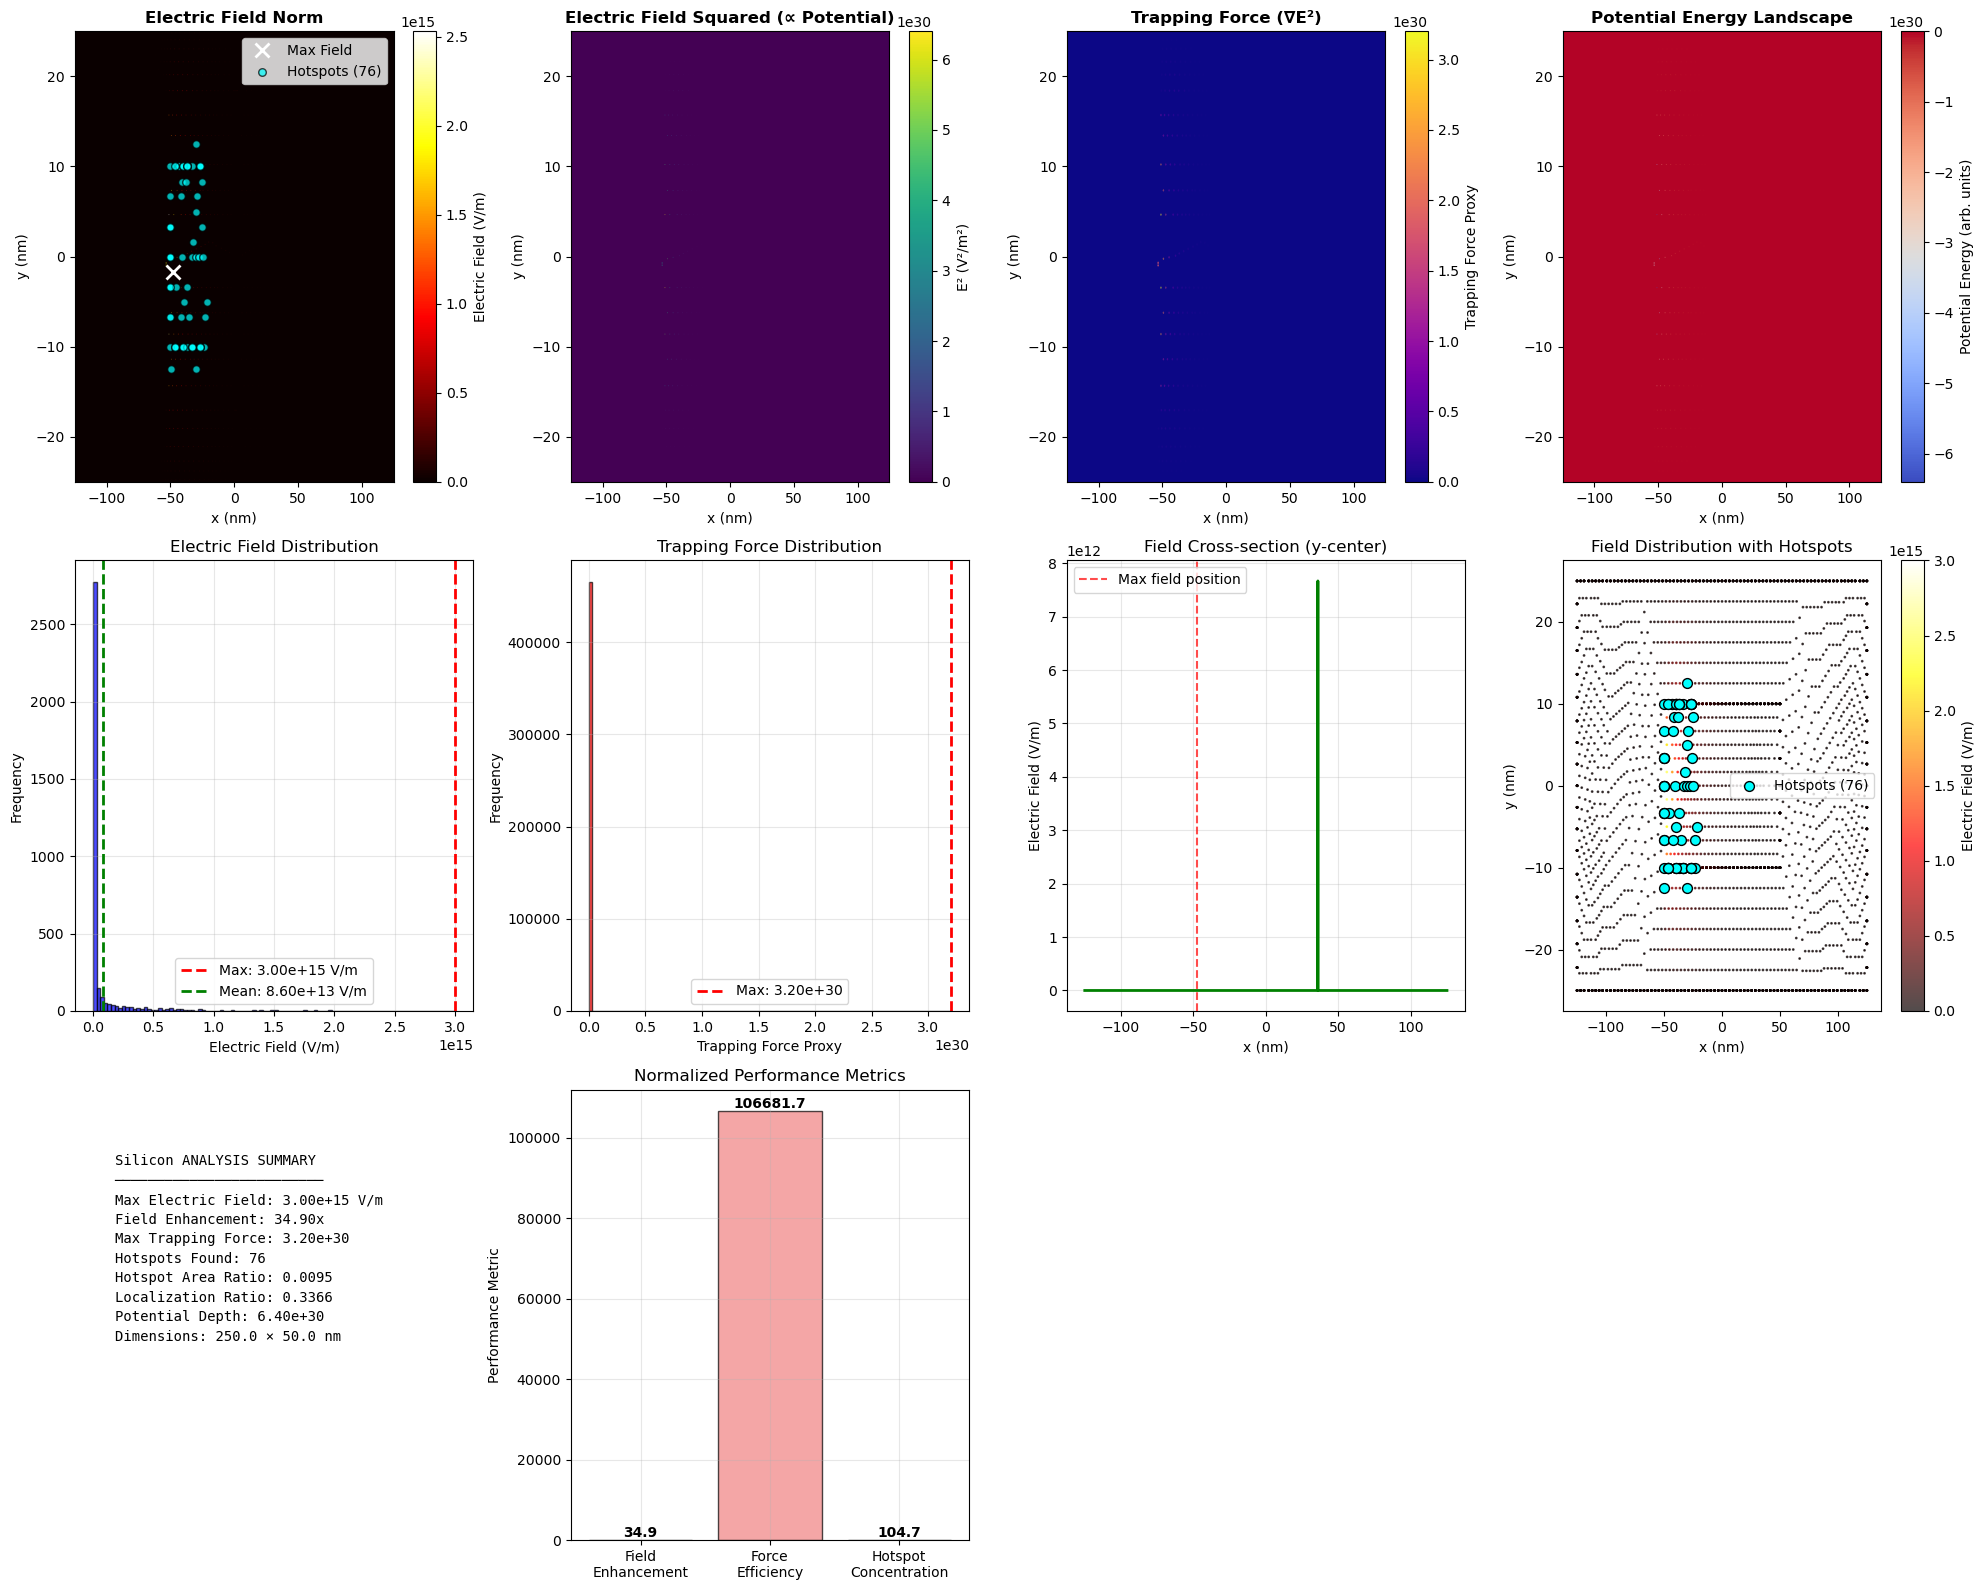


SAVING ANALYSIS RESULTS
ANALYSIS RESULTS SUMMARY:
                       Parameter         Value           Unit
0   Maximum Electric Field (V/m)      3.00e+15            V/m
1      Mean Electric Field (V/m)      8.60e+13            V/m
2       Field Enhancement Factor         34.90  dimensionless
3         Maximum Trapping Force      3.20e+30     arb. units
4            Mean Trapping Force      5.26e+26     arb. units
5              Force Enhancement       6080.42  dimensionless
6             Number of Hotspots            76          count
7             Hotspot Area Ratio        0.0095          ratio
8       Field Localization Ratio        0.3366          ratio
9           Potential Well Depth      6.40e+30     arb. units
10           Trapping Efficiency      1.07e+15    Force/Field
11       Spatial Dimensions (nm)  250.0 × 50.0             nm
✅ Results saved to 'silicon_analysis_results.csv'
✅ Hotspot positions saved to 'silicon_hotspot_positions.csv'

ANALYSIS COMPLETE! 🎉


In [2]:
# COMPLETE SILICON WAVEGUIDE ELECTRIC FIELD ANALYSIS - FIXED VERSION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
import os

print("="*70)
print("COMPLETE SILICON WAVEGUIDE ELECTRIC FIELD ANALYSIS")
print("="*70)

# Load your data with correct file path
file_path = r"C:\Users\USER\Desktop\photonics ml\silicon.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully!")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
except Exception as e:
    print(f"❌ Error loading file: {e}")
    print("Please check the file path and try again.")
    raise

# Display basic file information
print("\n" + "="*50)
print("FILE INFORMATION")
print("="*50)
print("First 5 rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")

# Check for NaN or Inf values
print(f"\nChecking for NaN/Inf values:")
print(f"NaN values in data: {df.isnull().sum().sum()}")
print(f"Inf values in data: {np.isinf(df.values).sum()}")

# Clean the data - remove NaN and Inf values
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Data shape after cleaning: {df_clean.shape}")

# Extract data - try different column naming patterns
print("\n" + "="*50)
print("EXTRACTING DATA COLUMNS")
print("="*50)

# Auto-detect columns
x_col, y_col, ef_col = None, None, None

for col in df_clean.columns:
    col_lower = col.lower()
    if any(pattern in col_lower for pattern in ['x', 'xcoord', 'x_position']):
        x_col = col
    elif any(pattern in col_lower for pattern in ['y', 'ycoord', 'y_position']):
        y_col = col
    elif any(pattern in col_lower for pattern in ['e', 'ef', 'field', 'electric', 'norm']):
        ef_col = col

# If auto-detection fails, use first three columns
if x_col is None: x_col = df_clean.columns[0]
if y_col is None: y_col = df_clean.columns[1] 
if ef_col is None: ef_col = df_clean.columns[2]

print(f"Using columns: X={x_col}, Y={y_col}, E-field={ef_col}")

x = df_clean[x_col].values
y = df_clean[y_col].values
ef = df_clean[ef_col].values

print(f"\nData ranges:")
print(f"X: {x.min():.2e} to {x.max():.2e} m")
print(f"Y: {y.min():.2e} to {y.max():.2e} m")
print(f"Electric Field: {ef.min():.2e} to {ef.max():.2e} V/m")

# Check for any remaining invalid values
if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isnan(ef)):
    print("❌ Warning: Still found NaN values after cleaning!")
    # Remove any remaining NaN values
    valid_mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(ef))
    x = x[valid_mask]
    y = y[valid_mask]
    ef = ef[valid_mask]
    print(f"Data shape after final cleaning: {len(x)}")

# Create 2D grid from scattered data
def create_2d_grid(x, y, values):
    """Convert scattered data to 2D grid"""
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    
    # Check if we have valid data
    if len(x_unique) == 0 or len(y_unique) == 0:
        print("❌ Error: No valid data points after cleaning!")
        return None, None, None
        
    grid = np.zeros((len(y_unique), len(x_unique)))
    
    for i, xi in enumerate(x_unique):
        for j, yj in enumerate(y_unique):
            mask = (x == xi) & (y == yj)
            if np.any(mask):
                grid[j, i] = values[mask][0]
    return grid, x_unique, y_unique

print("\nCreating 2D grid...")
grid_ef, x_uniq, y_uniq = create_2d_grid(x, y, ef)

# Check if grid creation was successful
if grid_ef is None:
    print("❌ Cannot proceed - no valid grid data!")
    exit()

print(f"Grid shape: {grid_ef.shape}")
print(f"X unique points: {len(x_uniq)}")
print(f"Y unique points: {len(y_uniq)}")

# 1. MAXIMUM ELECTRIC FIELD ANALYSIS
print("\n" + "="*50)
print("MAXIMUM ELECTRIC FIELD ANALYSIS")
print("="*50)

max_ef = np.max(ef)
max_ef_position = np.argmax(ef)
max_x, max_y = x[max_ef_position], y[max_ef_position]

print(f"🚀 MAXIMUM ELECTRIC FIELD: {max_ef:.2e} V/m")
print(f"📍 Position of maximum: x = {max_x:.2e} m, y = {max_y:.2e} m")

# 2. HOTSPOT ANALYSIS
print("\n" + "="*50)
print("HOTSPOT ANALYSIS")
print("="*50)

# Use more lenient parameters for hotspot detection
height_threshold = 0.1 * max_ef  # Lower threshold to find more hotspots
distance_threshold = 3  # Smaller distance between peaks

try:
    peaks_1d, properties = find_peaks(ef, height=height_threshold, distance=distance_threshold)
    
    if len(peaks_1d) > 0:
        hotspot_fields = ef[peaks_1d]
        hotspot_positions = list(zip(x[peaks_1d], y[peaks_1d]))
        
        print(f"🔍 Number of significant hotspots: {len(peaks_1d)}")
        print(f"🔥 Hotspot field range: {hotspot_fields.min():.2e} to {hotspot_fields.max():.2e} V/m")
        print(f"📊 Mean hotspot field: {hotspot_fields.mean():.2e} V/m")
        
        # Get top 5 strongest hotspots
        top_5_indices = np.argsort(hotspot_fields)[-5:][::-1]
        print(f"🏆 Top 5 strongest hotspots:")
        for i, idx in enumerate(top_5_indices):
            print(f"   {i+1}. Field: {hotspot_fields[idx]:.2e} V/m at ({x[peaks_1d[idx]]:.2e}, {y[peaks_1d[idx]]:.2e}) m")
            
    else:
        print("🔍 No significant hotspots found with current threshold.")
        print("💡 Try adjusting height_threshold or check your data distribution.")
        peaks_1d = np.array([])  # Empty array to avoid errors later
        hotspot_fields = np.array([])
        
except Exception as e:
    print(f"❌ Error in hotspot detection: {e}")
    peaks_1d = np.array([])
    hotspot_fields = np.array([])

# Field localization metrics
field_above_half_max = ef > 0.5 * max_ef
field_above_quarter_max = ef > 0.25 * max_ef
hotspot_area_ratio = np.sum(field_above_half_max) / len(ef) if len(ef) > 0 else 0
localization_ratio = (np.sum(field_above_half_max) / np.sum(field_above_quarter_max) 
                     if np.sum(field_above_quarter_max) > 0 else 0)

print(f"🎯 Hotspot area ratio (field > 50% max): {hotspot_area_ratio:.4f}")
print(f"🎯 Field localization ratio: {localization_ratio:.4f}")

# 3. TRAPPING FORCE ANALYSIS
print("\n" + "="*50)
print("TRAPPING FORCE ANALYSIS")
print("="*50)

# Calculate gradients for trapping force (Ftrap ∝ ∇E²)
field_squared = grid_ef**2
grad_ef_squared_y, grad_ef_squared_x = np.gradient(field_squared)

# Trapping force magnitude (proportional to gradient of E²)
trapping_force = np.sqrt(grad_ef_squared_x**2 + grad_ef_squared_y**2)

max_trapping_force = np.max(trapping_force)
mean_trapping_force = np.mean(trapping_force)

print(f"💪 MAXIMUM TRAPPING FORCE: {max_trapping_force:.2e}")
print(f"📊 MEAN TRAPPING FORCE: {mean_trapping_force:.2e}")
print(f"⚡ Force enhancement (Max/Mean): {max_trapping_force/mean_trapping_force:.2f}")

# Calculate potential energy landscape (U ∝ -E²)
potential_energy = -field_squared
min_potential = np.min(potential_energy)
max_potential = np.max(potential_energy)
potential_depth = max_potential - min_potential

print(f"🕳️ Potential well depth: {potential_depth:.2e}")

# 4. POWER EFFICIENCY METRICS
print("\n" + "="*50)
print("POWER EFFICIENCY METRICS")
print("="*50)

mean_ef = np.mean(ef)
field_enhancement = max_ef / mean_ef if mean_ef > 0 else 0
force_per_field = max_trapping_force / max_ef if max_ef > 0 else 0

print(f"📈 Field enhancement factor: {field_enhancement:.2f}")
print(f"⚡ Trapping efficiency (Force/Field): {force_per_field:.2e}")
print(f"🎯 Hotspot concentration factor: {1/hotspot_area_ratio:.2f}" if hotspot_area_ratio > 0 else "🎯 Hotspot concentration factor: N/A")

# 5. COMPREHENSIVE VISUALIZATION
print("\n" + "="*50)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*50)

# Create main figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# Calculate extent with safety checks
def safe_extent(x_uniq, y_uniq):
    """Calculate extent with NaN/Inf protection"""
    x_min = np.nanmin(x_uniq) * 1e9 if len(x_uniq) > 0 else 0
    x_max = np.nanmax(x_uniq) * 1e9 if len(x_uniq) > 0 else 1
    y_min = np.nanmin(y_uniq) * 1e9 if len(y_uniq) > 0 else 0
    y_max = np.nanmax(y_uniq) * 1e9 if len(y_uniq) > 0 else 1
    
    # Replace any remaining NaN/Inf with finite values
    x_min = x_min if np.isfinite(x_min) else 0
    x_max = x_max if np.isfinite(x_max) else 1
    y_min = y_min if np.isfinite(y_min) else 0
    y_max = y_max if np.isfinite(y_max) else 1
    
    return [x_min, x_max, y_min, y_max]

extent = safe_extent(x_uniq, y_uniq)
print(f"Using extent: {extent}")

# 5.1 Electric Field Norm
plt.subplot(3, 4, 1)
im1 = plt.imshow(grid_ef, extent=extent, origin='lower', cmap='hot', aspect='auto')
plt.colorbar(im1, label='Electric Field (V/m)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Electric Field Norm', fontweight='bold')

# Mark maximum field point
max_idx_2d = np.unravel_index(np.argmax(grid_ef), grid_ef.shape)
max_x_nm = x_uniq[max_idx_2d[1]] * 1e9 if len(x_uniq) > max_idx_2d[1] else extent[0]
max_y_nm = y_uniq[max_idx_2d[0]] * 1e9 if len(y_uniq) > max_idx_2d[0] else extent[2]
plt.plot(max_x_nm, max_y_nm, 'wx', markersize=10, markeredgewidth=2, label='Max Field')

# Mark hotspots if any were found
if len(peaks_1d) > 0:
    plt.scatter(x[peaks_1d]*1e9, y[peaks_1d]*1e9, c='cyan', s=30, edgecolors='black', 
                alpha=0.7, label=f'Hotspots ({len(peaks_1d)})')
plt.legend()

# 5.2 Electric Field Squared (Potential)
plt.subplot(3, 4, 2)
im2 = plt.imshow(field_squared, extent=extent, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(im2, label='E² (V²/m²)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Electric Field Squared (∝ Potential)', fontweight='bold')

# 5.3 Trapping Force
plt.subplot(3, 4, 3)
im3 = plt.imshow(trapping_force, extent=extent, origin='lower', cmap='plasma', aspect='auto')
plt.colorbar(im3, label='Trapping Force Proxy')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Trapping Force (∇E²)', fontweight='bold')

# 5.4 Potential Energy
plt.subplot(3, 4, 4)
im4 = plt.imshow(potential_energy, extent=extent, origin='lower', cmap='coolwarm', aspect='auto')
plt.colorbar(im4, label='Potential Energy (arb. units)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Potential Energy Landscape', fontweight='bold')

# 5.5 Electric Field Distribution Histogram
plt.subplot(3, 4, 5)
plt.hist(ef, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(max_ef, color='red', linestyle='--', linewidth=2, label=f'Max: {max_ef:.2e} V/m')
plt.axvline(mean_ef, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_ef:.2e} V/m')
plt.xlabel('Electric Field (V/m)')
plt.ylabel('Frequency')
plt.title('Electric Field Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 5.6 Trapping Force Distribution
plt.subplot(3, 4, 6)
plt.hist(trapping_force.flatten(), bins=100, alpha=0.7, color='red', edgecolor='black')
plt.axvline(max_trapping_force, color='red', linestyle='--', linewidth=2, 
            label=f'Max: {max_trapping_force:.2e}')
plt.xlabel('Trapping Force Proxy')
plt.ylabel('Frequency')
plt.title('Trapping Force Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 5.7 Field Cross-section through maximum
plt.subplot(3, 4, 7)
if len(x_uniq) > 0:
    center_y_index = len(y_uniq) // 2 if len(y_uniq) > 0 else 0
    if center_y_index < grid_ef.shape[0]:
        field_line = grid_ef[center_y_index, :]
        plt.plot(x_uniq*1e9, field_line, 'g-', linewidth=2)
        plt.axvline(max_x_nm, color='red', linestyle='--', alpha=0.7, label='Max field position')
        plt.xlabel('x (nm)')
        plt.ylabel('Electric Field (V/m)')
        plt.title('Field Cross-section (y-center)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No cross-section data', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Field Cross-section')
else:
    plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Field Cross-section')

# 5.8 Scatter plot with hotspots
plt.subplot(3, 4, 8)
scatter = plt.scatter(x*1e9, y*1e9, c=ef, cmap='hot', s=1, alpha=0.7)
plt.colorbar(scatter, label='Electric Field (V/m)')
if len(peaks_1d) > 0:
    plt.scatter(x[peaks_1d]*1e9, y[peaks_1d]*1e9, c='cyan', s=50, edgecolors='black', 
                marker='o', label=f'Hotspots ({len(peaks_1d)})')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title('Field Distribution with Hotspots')
if len(peaks_1d) > 0:
    plt.legend()

# 5.9 Summary Statistics
plt.subplot(3, 4, 9)
plt.axis('off')
summary_text = f"""
Silicon ANALYSIS SUMMARY
─────────────────────────
Max Electric Field: {max_ef:.2e} V/m
Field Enhancement: {field_enhancement:.2f}x
Max Trapping Force: {max_trapping_force:.2e}
Hotspots Found: {len(peaks_1d)}
Hotspot Area Ratio: {hotspot_area_ratio:.4f}
Localization Ratio: {localization_ratio:.4f}
Potential Depth: {potential_depth:.2e}
Dimensions: {extent[1]-extent[0]:.1f} × {extent[3]-extent[2]:.1f} nm
"""
plt.text(0.1, 0.9, summary_text, fontfamily='monospace', fontsize=10, 
         verticalalignment='top', linespacing=1.5)

# 5.10 Performance Metrics (only if we have hotspots)
plt.subplot(3, 4, 10)
if hotspot_area_ratio > 0:
    metrics = ['Field\nEnhancement', 'Force\nEfficiency', 'Hotspot\nConcentration']
    values = [field_enhancement, force_per_field/1e10, 1/hotspot_area_ratio]
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.7)
    plt.ylabel('Performance Metric')
    plt.title('Normalized Performance Metrics')
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'Performance metrics\nnot available\n(no hotspots found)', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Performance Metrics')

plt.tight_layout()
plt.show()

# 6. SAVE RESULTS
print("\n" + "="*50)
print("SAVING ANALYSIS RESULTS")
print("="*50)

# Create comprehensive results dataframe
results = {
    'Parameter': [
        'Maximum Electric Field (V/m)',
        'Mean Electric Field (V/m)', 
        'Field Enhancement Factor',
        'Maximum Trapping Force',
        'Mean Trapping Force',
        'Force Enhancement',
        'Number of Hotspots',
        'Hotspot Area Ratio',
        'Field Localization Ratio',
        'Potential Well Depth',
        'Trapping Efficiency',
        'Spatial Dimensions (nm)'
    ],
    'Value': [
        f"{max_ef:.2e}",
        f"{mean_ef:.2e}",
        f"{field_enhancement:.2f}",
        f"{max_trapping_force:.2e}",
        f"{mean_trapping_force:.2e}",
        f"{max_trapping_force/mean_trapping_force:.2f}",
        f"{len(peaks_1d)}",
        f"{hotspot_area_ratio:.4f}",
        f"{localization_ratio:.4f}",
        f"{potential_depth:.2e}",
        f"{force_per_field:.2e}",
        f"{extent[1]-extent[0]:.1f} × {extent[3]-extent[2]:.1f}"
    ],
    'Unit': [
        'V/m', 'V/m', 'dimensionless', 'arb. units', 'arb. units', 
        'dimensionless', 'count', 'ratio', 'ratio', 'arb. units',
        'Force/Field', 'nm'
    ]
}

results_df = pd.DataFrame(results)
print("ANALYSIS RESULTS SUMMARY:")
print(results_df)

# Save results to CSV
results_df.to_csv('silicon_analysis_results.csv', index=False)
print("✅ Results saved to 'silicon_analysis_results.csv'")

# Save hotspot positions if any were found
if len(peaks_1d) > 0:
    hotspot_df = pd.DataFrame({
        'x_position_m': x[peaks_1d],
        'y_position_m': y[peaks_1d], 
        'electric_field_Vm': ef[peaks_1d]
    })
    hotspot_df.to_csv('silicon_hotspot_positions.csv', index=False)
    print("✅ Hotspot positions saved to 'silicon_hotspot_positions.csv'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE! 🎉")
print("="*70)